In [141]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np


class Bandit(object):
    def __init__(self, n_arms):
        # each arm is a gaussian with mean randomly sampled from ~N(0, 1)
        self.bandits_mu = stats.norm(0, 1).rvs(n_arms)
        
        # remembers the best arm
        self.best_arm = np.argmax(self.bandits_mu)
        
        # instantiate the gaussians arms with predefined mu and variance 1
        self.arms = [stats.norm(mu, 1) for mu in self.bandits_mu]
        
    def play(self, arm):
        """
        Returns the reward of playing a given arm
        """
        return self.arms[arm].rvs(1)[0]



In [158]:
class Experiment(object):
    def __init__(self, env, agent):
        self.env = env
        self.agent = agent
        self.trials = trials
        self.actions = []
        self.rewards = []
        
    def reset(self):
        self.actions = []
        self.rewards = []
        
    def run(self, trials):
        for i in range(trials):
            action = self.agent.act()
            self.actions.append(action)

            reward = self.env.play(action)
            self.rewards.append(reward)

            self.agent.learn(action, reward)

In [159]:
class UniformAgent(object):
    def __init__(self, bandit):
        self.bandit = bandit
        
        # assigns uniformly random probs. to arms, then normalize
        self.probabilities = stats.uniform(0, 1).rvs(len(bandit.arms))
        
        sum_probs = sum(self.probabilities)
        
        # normalizes
        self.probabilities = [p / sum_probs for p in self.probabilities]
        
        #checks
        assert np.isclose(1, sum(self.probabilities))
        
        #saves cumulative probabilities:
        self.cumprobs = np.cumsum(self.probabilities)
        
    def act(self):
        """
        Selects an arm in proportion with the probabilities
        """
        # code copied from OpenAI Gym gym/envs/toy_text/discrete.py
        return (self.cumprobs > np.random.rand()).argmax()
        
    def argmax(self):
        """
        Returns the arm with highest probability
        """
        return np.argmax(self.probabilities)
    
    def epsilon_argmax(self, epsilon):
        if np.random.random() < epsilon:
            return np.random.randint(0, len(self.probabilities))  
        return self.greedy()
    
# uncomment to test uniform agent
"""
b = Bandit(10)
a = UniformAgent(b)
print(a.argmax())
plt.hist([a.act() for _ in range(10000)])
plt.show()
"""
pass #prevents outputting the comment string

In [160]:
class UniformBiasedAgent(UniformAgent):
    def __init__(self, bandit):
        self.bandit = bandit
        
        # samples the prob of choosing the best arm from [0, 1]
        p_best = stats.uniform(0, 1).rvs(1)[0]
        
        # samples the prob of choosing the other arms from [0, 1-p_best]
        p_others = stats.uniform(0, 1 - p_best).rvs(len(bandit.arms) -1)  
               
        # normalizes
        sum_others = sum(p_others)
        #norm_factor = sum_others*(1 - p_best)
        p_others = [p *(1 - p_best) / sum_others for p in p_others]
        
        #print(p_best, sum_others, sum(p_others))
        
        # finally assigns the probabilities
        offset = 0 # helps on getting the prob. from correct position
        self.probabilities = np.zeros(len(bandit.arms))
        for i, arm in enumerate(bandit.arms):
            if i == bandit.best_arm:
                self.probabilities[i] = p_best
                offset = 1 # to discount that I'm not getting p_others[i] in this iteration
            else:
                self.probabilities[i] = p_others[i - offset]
        
        #checks
        assert np.isclose(1, sum(self.probabilities))
        
        #saves cumulative probabilities:
        self.cumprobs = np.cumsum(self.probabilities)

# uncomment to test uniform biased agent
"""
b = Bandit(10)
a = UniformBiasedAgent(b)
print(a.argmax())
plt.hist([a.act() for _ in range(10000)])
plt.show()
"""
pass # prevents outputting a comment string

In [161]:
class LearningAgent(object):
    def __init__(self, bandit, alpha=0.1):
        self.bandit = bandit
        self.alpha = alpha
        self.q = np.zeros(len(bandit.arms))
        self.last_choice = None
        
    def act(self, epsilon=0.1):
        """
        Epsilon greedy over actions
        """
        if np.random.random() < epsilon:
            self.last_choice =  np.random.randint(0, len(self.q))  
        else:
            self.last_choice = np.argmax(self.q)
        
        return self.last_choice
    
    def learn(self, choice, reward):
        """
        Q-learning update rule (without states for now)
        """
        self.q[choice] = self.q[choice] + self.alpha*(reward - self.q[choice])
        
# uncomment to test the learning agent 
"""
trials = 10000
env = Bandit(100)
learner = LearningAgent(env)

exp = Experiment(env, learner)
exp.run(trials)
    
#stats:
freq_best = sum([1 for x in exp.actions if x == env.best_arm])

print("% best:", freq_best / trials)
#plt.hist(actions)
#plt.hist(rewards)
#plt.plot(np.convolve(rewards, np.ones((100,))/100, mode='valid')) #running average: https://stackoverflow.com/a/22621523
#plt.show()
"""
pass

In [162]:
class Controller(object):
    def __init__(self, team, alpha=0.1):
        """
        Receives the array of agents
        """
        self.team = team
        self.q = [0 for _ in self.team]
        self.last_choice = None
        self.last_agent_index = None
        self.alpha = alpha
        
    def act(self, epsilon=0.1):
        """
        Epsilon greedy over agents
        """
        
        if np.random.random() < epsilon:
            self.last_agent_index =  np.random.randint(0, len(self.q))  
        else:
            self.last_agent_index = np.argmax(self.q)
        
        self.last_choice = self.team[self.last_agent_index].act()
        
        return self.last_choice
    
    def learn(self, choice, reward):
        """
        Q-learning update rule (without states for now)
        """
        a = self.last_agent_index
        self.q[a] = self.q[a] + self.alpha*(reward - self.q[a])


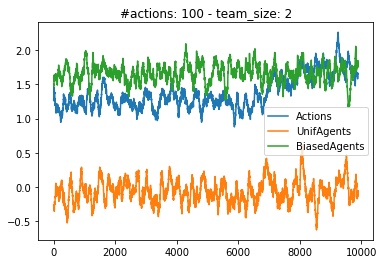

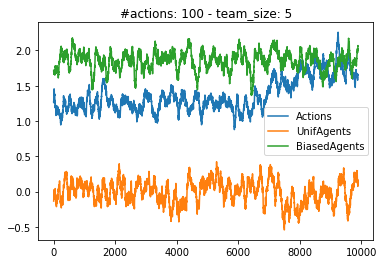

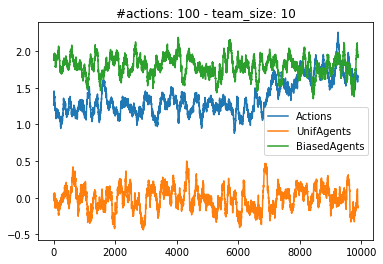

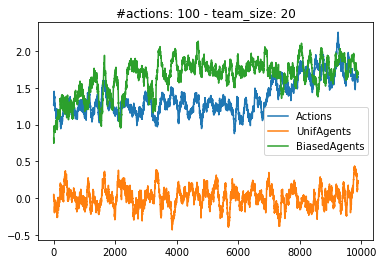

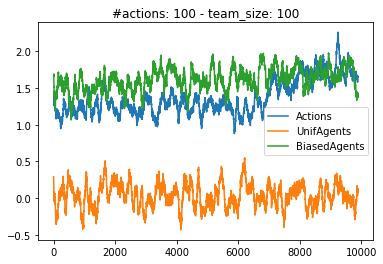

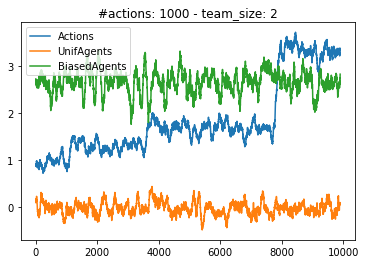

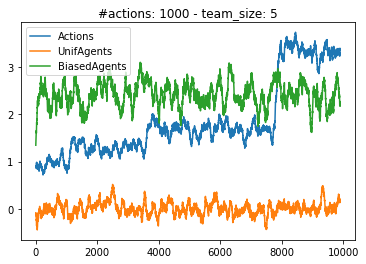

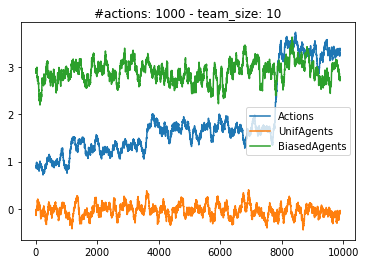

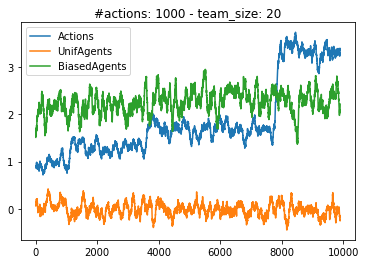

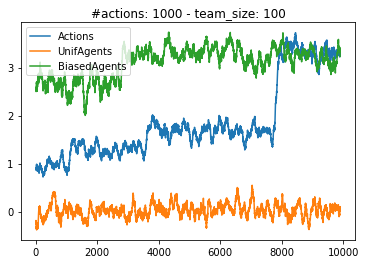

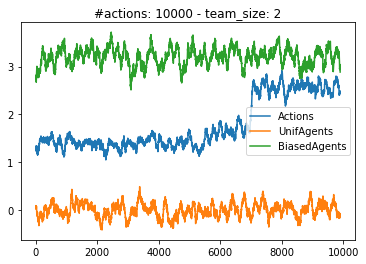

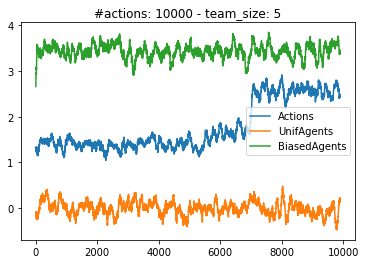

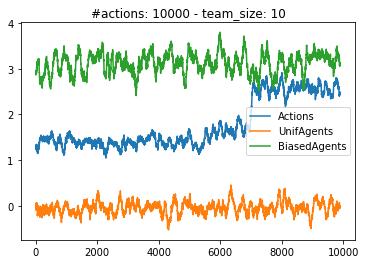

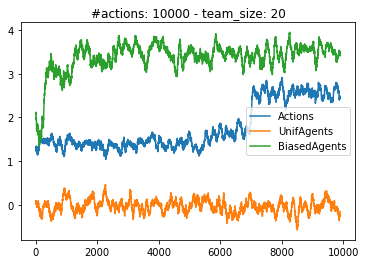

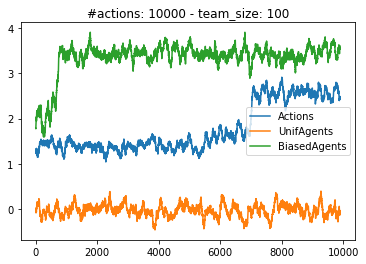

In [163]:
# The real test

team_sizes = [2, 5, 10, 20, 100]     
bandit_sizes = [100, 1000, 10000]
trials = 10000

for n_arms in bandit_sizes:
    bandit = Bandit(n_arms)
    
    learner = LearningAgent(env)
    over_actions = Experiment(bandit, learner)
    over_actions.run(trials)
    
    freq_best_actions = sum([1 for x in over_actions.actions if x == bandit.best_arm])
    total_rwd_actions = sum(over_actions.rewards)
    
    for team_sz in team_sizes:
        team_unif = [UniformAgent(bandit) for _ in range(team_sz)]
        team_ubias = [UniformBiasedAgent(bandit) for _ in range(team_sz)]
        
        ctrl_unif = Controller(team_unif)
        ctrl_ubias = Controller(team_ubias
                               )
        over_unif_agents = Experiment(bandit, ctrl_unif)
        over_unif_agents.run(trials)
        
        over_biased_agents = Experiment(bandit, ctrl_ubias)
        over_biased_agents.run(trials)
        
        """
        freq_best_agents = sum([1 for x in over_unif_agents.actions if x == bandit.best_arm])
        total_rwd_agents = sum(over_unif_agents.rewards)
        
        print("---- #Actions %d / team_size %d ----" % (n_arms, team_sz))
        print("% best (agents) :", freq_best_agents / trials)
        print("% best (actions):", freq_best_actions / trials)
        
        print("rwd (agents) : ", total_rwd_agents)
        print("rwd (actions): ", total_rwd_actions)
        """
        
        #plt.plot(over_agents.rewards)
        #plt.plot(over_actions.rewards)
        plt.plot(np.convolve(over_actions.rewards, np.ones((100,))/100, mode='valid'), label="Over Actions") 
        plt.plot(np.convolve(over_unif_agents.rewards, np.ones((100,))/100, mode='valid'), label="Over Actions") 
        plt.plot(np.convolve(over_biased_agents.rewards, np.ones((100,))/100, mode='valid'), label="Over Agents") #running average: https://stackoverflow.com/a/22621523
        
        plt.legend(['Actions', 'UnifAgents', 'BiasedAgents'])
        plt.title("#actions: %d - team_size: %d"  % (n_arms, team_sz))
        plt.show()
            
        